# Lookup table inversion
## Using exact solution values
### Halfspace case

In [1]:
import empymod
import numpy as np
import matplotlib.pyplot as plt
import time
from joblib import Parallel, delayed
from scipy.constants import mu_0

### Define the geometry of device

In [6]:
# Define Dualem-482 geometry

offsets = np.array([2, 4, 8]) # in meters
height = -0.10 # meters height From ground surface to center of coils
rad = 0.08 # Define radius of coil (8 cm)

# Source and receivers geometry

# For HCP
Hsource = [-rad, rad, -rad, rad, height, height]
Hreceivers = [offsets-rad, offsets+rad,
              np.ones(3)*-rad, np.ones(3)*rad, height, height]

# For VCP
Vsource = [0, 0, height, 90, 0]
Vreceivers = [offsets, offsets*0, height, 90, 0]

# For PRP
Psource = [0, 0, height]
Preceivers = [offsets, offsets*0, height]

# Frequency
freq = 9000

### Define the properties of the models of the lookup table

In [10]:
# sampling of conductivities
nsl = 81

s0 = -4 # minimum conductivity in S/m
s1 = -0.5 # maximum conductivity in S/m
# conductivities array
conds = np.logspace(s0, s1, nsl)

In [11]:
def EMforward(sigma):
    time.sleep(0.01)
    
    res =[2e14, 1/sigma]
    depth=[0]

    # Compute fields
    HCP_Hs = empymod.loop(Hsource, Hreceivers, depth, res, freq, xdirect=None, mrec = 'loop', verb=0)
    VCP_Hs = empymod.loop(Vsource, Vreceivers, depth, res, freq, xdirect=None, mrec = 'loop', verb=0)
    PRP_Hs = empymod.dipole(Psource, Preceivers, depth, res, freq, ab=64, xdirect=None, verb=0)

    HCP_Hp = empymod.loop(Hsource, Hreceivers, depth=[], res=[2e14], freqtime=freq, mrec = 'loop', verb=0)
    VCP_Hp = empymod.loop(Vsource, Vreceivers, depth=[], res=[2e14], freqtime=freq, mrec = 'loop', verb=0)
    PRP_Hp = empymod.dipole(Psource, Preceivers, depth=[], res=[2e14], freqtime=freq, ab=66, verb=0)

    Q_HCP = np.abs(np.imag(HCP_Hs/HCP_Hp))
    Q_VCP = np.abs(np.imag(VCP_Hs/VCP_Hp))
    Q_PRP = np.abs(np.imag(PRP_Hs/PRP_Hp))
    
    P_HCP = np.abs(np.real(HCP_Hs/HCP_Hp))
    P_VCP = np.abs(np.real(VCP_Hs/VCP_Hp))
    P_PRP = np.abs(np.real(PRP_Hs/PRP_Hp))
    
    return np.hstack((Q_HCP, Q_VCP, Q_PRP, P_HCP, P_VCP, P_PRP))

In [12]:
startTime = time.time()

Qexact = Parallel(n_jobs=-1,verbose=1)(delayed(EMforward)(sigma) for sigma in conds)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Execution time in seconds: 0.45576953887939453


[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    0.4s finished


### Define functions that search smallest error index

In [13]:
def gridsearch(Qdata):
    err = 1
    indx=0
    for i in range(np.shape(Qexact)[0]):
        nZdiff = np.abs(Qexact[i] - Qdata) **2 / np.abs(Qdata)**2
        merr = np.log(np.sqrt(np.sum(nZdiff)))
        if merr < err:
            indx = i
            err = merr.copy()
    return indx

In [18]:
# Inputs for inversion:

# Create empty array for true model in each position
model = []

# Create empty array for true data in each position
data=[]

s0 = -4 # minimum conductivity in S/m
s1 = -0.5 # maximum conductivity in S/m
# conductivities array
model_conds = np.logspace(s0, s1, nsl)

for i in range(len(conds)):
    model_i = model_conds[i] # True model 
    model.append(model_i)
    data.append(EMforward(model_i)) # creating data

In [19]:
# Start inversion

model_est_list =[] # empty array to store the model estimated

for i in range(len(conds)):   
    dataE = np.array(data[i]).copy()
    #dataE *= np.random.randn(len(dataE)) * relativeError + 1.0

    model_est = conds[gridsearch(dataE)]
    
    model_est_list.append(model_est)

# Model estimation array  
model_est_arr = np.array(model_est_list)

/tmp/ipykernel_966/3073962735.py:6: RuntimeWarning: divide by zero encountered in log
  merr = np.log(np.sqrt(np.sum(nZdiff)))


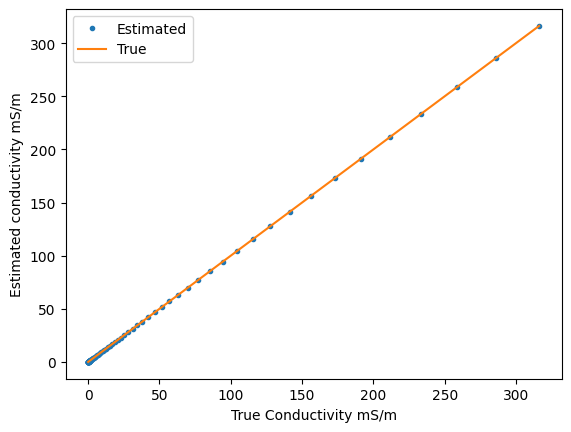

In [20]:
# Plot estimated model

plt.plot(model_conds*1000, model_est_arr*1000, '.', label='Estimated')
plt.plot(model_conds*1000, model_conds*1000, label = 'True')
plt.xlabel('True Conductivity mS/m')
plt.ylabel('Estimated conductivity mS/m')
plt.legend()